# **Travel Insurance**
Created by: Shatara Virlyza

## **Business Problem Understanding**

**Context**

Perusahaan asuransi perjalanan memiliki sejumlah besar data pelanggan yang mencakup informasi terkait penjualan polis, karakteristik perjalanan, profil pelanggan, serta status klaim asuransi. Namun, hanya sebagian kecil pelanggan yang benar-benar mengajukan klaim. Dalam konteks ini, perusahaan ingin memahami pola dan karakteristik pelanggan yang cenderung melakukan klaim agar dapat mengelola risiko klaim lebih baik, meningkatkan evaluasi dan persetujuan polis, dan merancang strategi pricing dan proteksi yang lebih efisien.

**Target**:

Yes (1): Pelanggan melakukan klaim terhadap asuransi perjalanan yang dibeli.

No (0): Pelanggan tidak melakukan klaim atas asuransi yang dibeli.

**Problem Statement:**

Bagaimana membangun model klasifikasi yang mampu mengidentifikasi secara akurat pelanggan yang berpotensi mengajukan klaim asuransi perjalanan, berdasarkan data historis pelanggan dan transaksi, agar perusahaan dapat memitigasi risiko, meningkatkan efisiensi proses underwriting, dan mengoptimalkan profitabilitas?

**Goals:**

- Mengembangkan model machine learning untuk memprediksi apakah seorang pelanggan akan mengajukan klaim asuransi perjalanan atau tidak.
- Mengoptimalkan metrik evaluasi yang fokus pada F2-score agar potensi False Negative (klaim yang lolos tanpa terdeteksi) diminimalkan.
- Mengidentifikasi fitur-fitur yang paling berpengaruh terhadap kemungkinan terjadinya klaim.
- Menyediakan interpretasi prediksi model secara transparan menggunakan pendekatan Explainable AI (SHAP & LIME).

**Analytic Approach:**

Analytical approach yang digunakan dalam proyek ini dimulai dengan eksplorasi data (EDA) untuk memahami karakteristik pelanggan dan pola klaim asuransi. Selanjutnya, dilakukan preprocessing data seperti scaling pada fitur numerik dan encoding pada fitur kategorikal. Mengingat data sangat imbalanced, digunakan teknik resampling seperti RandomUnderSampler untuk menyeimbangkan distribusi kelas. Model klasifikasi seperti Logistic Regression dan Random Forest kemudian dilatih dan dievaluasi dengan fokus pada metrik F2-score, karena lebih menekankan pada recall. Setelah model terbaik diperoleh, dilakukan hyperparameter tuning untuk mengoptimalkan performa. Terakhir, diterapkan teknik Explainable AI seperti SHAP dan LIME untuk memahami kontribusi fitur terhadap prediksi model secara lebih transparan dan interpretable.

## Data Understanding

Dataset source: [Data_Travel_Insurance](https://www.kaggle.com/datasets/mhdzahier/travel-insurance/data)

## Attribute Information

-	**Agency**: Name of agency.
-	**Agency Type**: Type of travel insurance agencies.
-	**Distribution Channel**: Channel of travel insurance agencies.
-	**Product Name**: Name of the travel insurance products.
-	**Gender**: Gender of insured.
-	**Duration**: Duration of travel.
-	**Destination**: Destination of travel.
-	**Net Sales**: Amount of sales of travel insurance policies.
-	**Commission (in value)**: Commission received for travel insurance agency.
-	**Age**: Age of insured.
-	**Claim**: Claim status.

In [289]:
# System & Warnings
import warnings
warnings.filterwarnings('ignore')

# Data Handling & Visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno

# Preprocessing
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer

# Handling Imbalanced Data
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler, NearMiss

# Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

# Evaluation Metrics
from sklearn.metrics import (
    fbeta_score, f1_score, make_scorer,
    confusion_matrix, classification_report, ConfusionMatrixDisplay
)

# Hyperparameter Tuning
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Explainability
import shap
import lime
import lime.lime_tabular


## **Load Dataset**

In [290]:
df = pd.read_csv('data_travel_insurance.csv')
df.head()

,Agency,Agency Type,Distribution Channel,Product Name,Gender,Duration,Destination,Net Sales,Commision (in value),Age,Claim
0,C2B,Airlines,Online,Annual Silver Plan,F,365,SINGAPORE,216.0,54.0,57,No
1,EPX,Travel Agency,Online,Cancellation Plan,NaN,4,MALAYSIA,10.0,0.0,33,No
2,JZI,Airlines,Online,Basic Plan,M,19,INDIA,22.0,7.7,26,No
3,EPX,Travel Agency,Online,2 way Comprehensive Plan,NaN,20,UNITED STATES,112.0,0.0,59,No
4,C2B,Airlines,Online,Bronze Plan,M,8,SINGAPORE,16.0,4.0,28,No


**klasifikasi**:
- Kategorikal:
  - Nominal: Agency, Agency Type, Distribution Channel, Product Name, Gender, Destination, Claim
- Numerikal:
  - Diskrit: Duration
  - Kontinu: Net Sales, Commision, Age

In [291]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44328 entries, 0 to 44327
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Agency                44328 non-null  object 
 1   Agency Type           44328 non-null  object 
 2   Distribution Channel  44328 non-null  object 
 3   Product Name          44328 non-null  object 
 4   Gender                12681 non-null  object 
 5   Duration              44328 non-null  int64  
 6   Destination           44328 non-null  object 
 7   Net Sales             44328 non-null  float64
 8   Commision (in value)  44328 non-null  float64
 9   Age                   44328 non-null  int64  
 10  Claim                 44328 non-null  object 
dtypes: float64(2), int64(2), object(7)
memory usage: 3.7+ MB


In [292]:
df.isna().sum()

,0
Agency,0
Agency Type,0
Distribution Channel,0
Product Name,0
Gender,31647
Duration,0
Destination,0
Net Sales,0
Commision (in value),0
Age,0


Terdapat missing value pada kolom 'Gender' sebanyak 31 ribu. Karena nilai tersebut terlalu besar, sehingga saya memustuskan untuk melakukan drop kolom

In [293]:
df.duplicated().sum()

np.int64(4667)

In [294]:
df.columns

Index(['Agency', 'Agency Type', 'Distribution Channel', 'Product Name',
       'Gender', 'Duration', 'Destination', 'Net Sales',
       'Commision (in value)', 'Age', 'Claim'],
      dtype='object')

## **EDA**

Langkah pertama adalah melakukan data cleaning terhadap data yang hilang/duplikat.

In [295]:
listItem = []
for col in df.columns :
    listItem.append([col, df[col].dtype, df[col].isna().sum(), round((df[col].isna().sum()/len(df[col])) * 100,2),
                    df[col].nunique(), list(df[col].drop_duplicates().sample(2).values)]);

dfDesc = pd.DataFrame(columns=['dataFeatures', 'dataType', 'null', 'nullPct', 'unique', 'uniqueSample'],
                     data=listItem)
dfDesc

,dataFeatures,dataType,null,nullPct,unique,uniqueSample
0,Agency,object,0,0.00,16,"[LWC, EPX]"
1,Agency Type,object,0,0.00,2,"[Travel Agency, Airlines]"
2,Distribution Channel,object,0,0.00,2,"[Offline, Online]"
3,Product Name,object,0,0.00,26,"[24 Protect, Single Trip Travel Protect Silver]"
4,Gender,object,31647,71.39,2,"[M, nan]"
5,Duration,int64,0,0.00,437,"[40, 54]"
6,Destination,object,0,0.00,138,"[NAMIBIA, IRAN, ISLAMIC REPUBLIC OF]"
7,Net Sales,float64,0,0.00,1006,"[207.0, 101.0]"
8,Commision (in value),float64,0,0.00,915,"[60.04, 6.5]"
9,Age,int64,0,0.00,89,"[50, 39]"


In [296]:
df['Gender'].unique()

array(['F', nan, 'M'], dtype=object)

In [297]:
df['Gender'].value_counts()

,count
Gender,
M,6504
F,6177


In [298]:
dfClean = df.copy()

# Drop Missing Value
dfClean = dfClean.drop(columns='Gender')

# Remove Duplicate
dfClean = dfClean.drop_duplicates()

In [299]:
print(dfClean.isna().sum())
print("Jumlah baris duplikat di dfClean:", dfClean.duplicated().sum())

Agency                  0
Agency Type             0
Distribution Channel    0
Product Name            0
Duration                0
Destination             0
Net Sales               0
Commision (in value)    0
Age                     0
Claim                   0
dtype: int64
Jumlah baris duplikat di dfClean: 0


Sekarang data sudah aman dan bersih

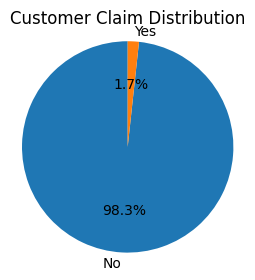

In [300]:
# Pie chart - Distribusi Claim
churn_counts = dfClean['Claim'].value_counts()
plt.figure(figsize=(3, 3))
plt.pie(
    churn_counts,
    labels=['No', 'Yes'],
    autopct='%1.1f%%',
    startangle=90
)
plt.title('Customer Claim Distribution')
plt.axis('equal')
plt.show()

Insight:
- Dataset tidak imbalance, memiliki sekitar 98% customer tidak mengklaim asuransi, dan sisanya 1% mengklaim

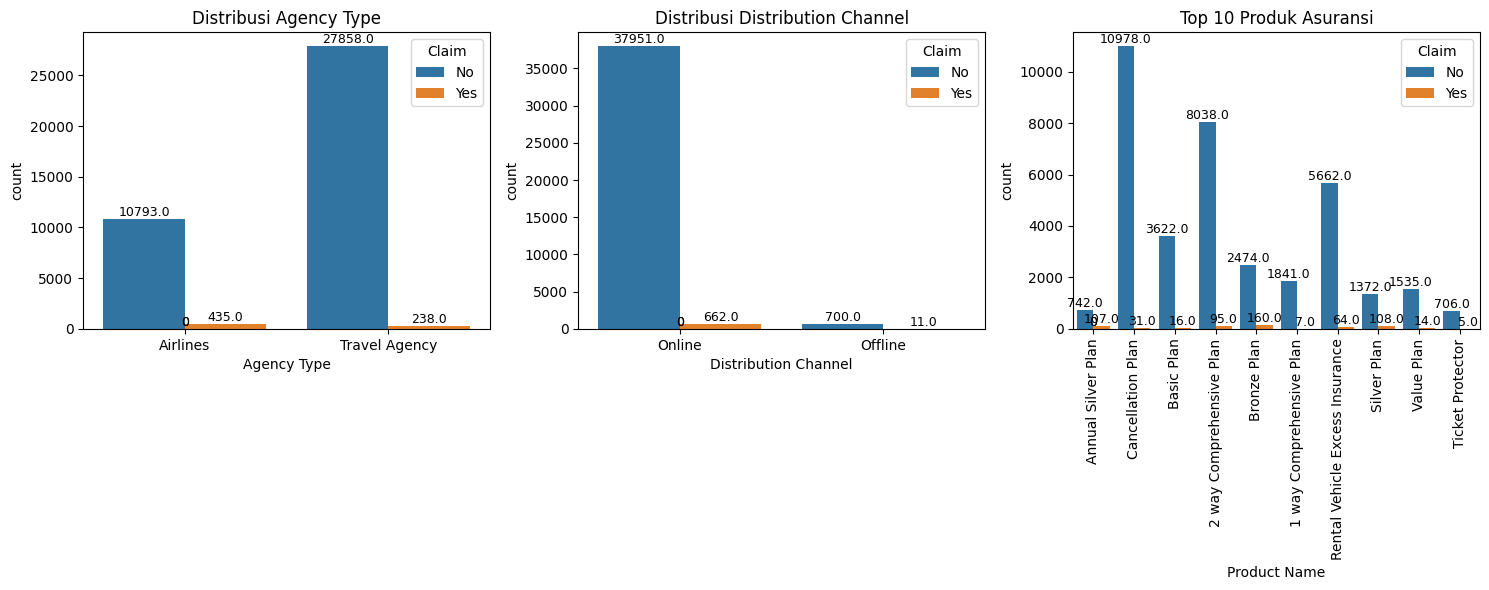

In [301]:
fig, axs = plt.subplots(1, 3, figsize=(15, 6))

# 1. Agency Type
ax0 = sns.countplot(x='Agency Type', hue='Claim', data=dfClean, ax=axs[0])
axs[0].set_title("Distribusi Agency Type")

for p in ax0.patches:
    height = p.get_height()
    ax0.annotate(f'{height}',
                 (p.get_x() + p.get_width() / 2., height),
                 ha='center', va='bottom', fontsize=9)

# 2. Distribution Channel
ax1 = sns.countplot(x='Distribution Channel', hue='Claim', data=dfClean, ax=axs[1])
axs[1].set_title("Distribusi Distribution Channel")

for p in ax1.patches:
    height = p.get_height()
    ax1.annotate(f'{height}',
                 (p.get_x() + p.get_width() / 2., height),
                 ha='center', va='bottom', fontsize=9)

# 3. Product Name (Top 10)
top_products = dfClean['Product Name'].value_counts().nlargest(10).index
df_top_products = dfClean[dfClean['Product Name'].isin(top_products)]

ax2 = sns.countplot(x='Product Name', hue='Claim', data=df_top_products, ax=axs[2])
axs[2].set_title("Top 10 Produk Asuransi")
axs[2].tick_params(axis='x', rotation=90)

for p in ax2.patches:
    height = p.get_height()
    ax2.annotate(f'{height}',
                 (p.get_x() + p.get_width() / 2., height),
                 ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

**Insights**:

1. Distribusi Agency Type vs Claim

  - Travel Agency mendominasi jumlah data secara keseluruhan, dengan jumlah klaim Yes yang sangat sedikit dibandingkan No.
  - Airlines juga menunjukkan jumlah klaim Yes sangat rendah dibanding total transaksi.

2. Distribusi Distribution Channel vs Claim
  - Mayoritas pembelian dilakukan secara Online, dan sangat sedikit melalui Offline.
  - Jumlah klaim tetap rendah, bahkan di channel yang dominan.
  - Pembelian asuransi jauh lebih banyak dilakukan secara online.

3. Top 10 Produk Asuransi vs Claim
  - Produk Cancellation Plan dan 2 way Comprehensive Plan adalah yang paling banyak dibeli.
  - Mayoritas produk tidak mengalami klaim.
  - Beberapa produk seperti “Annual Silver Plan” memiliki jumlah total paling sedikit, namun perlu dicek rasio klaimnya lebih lanjut.

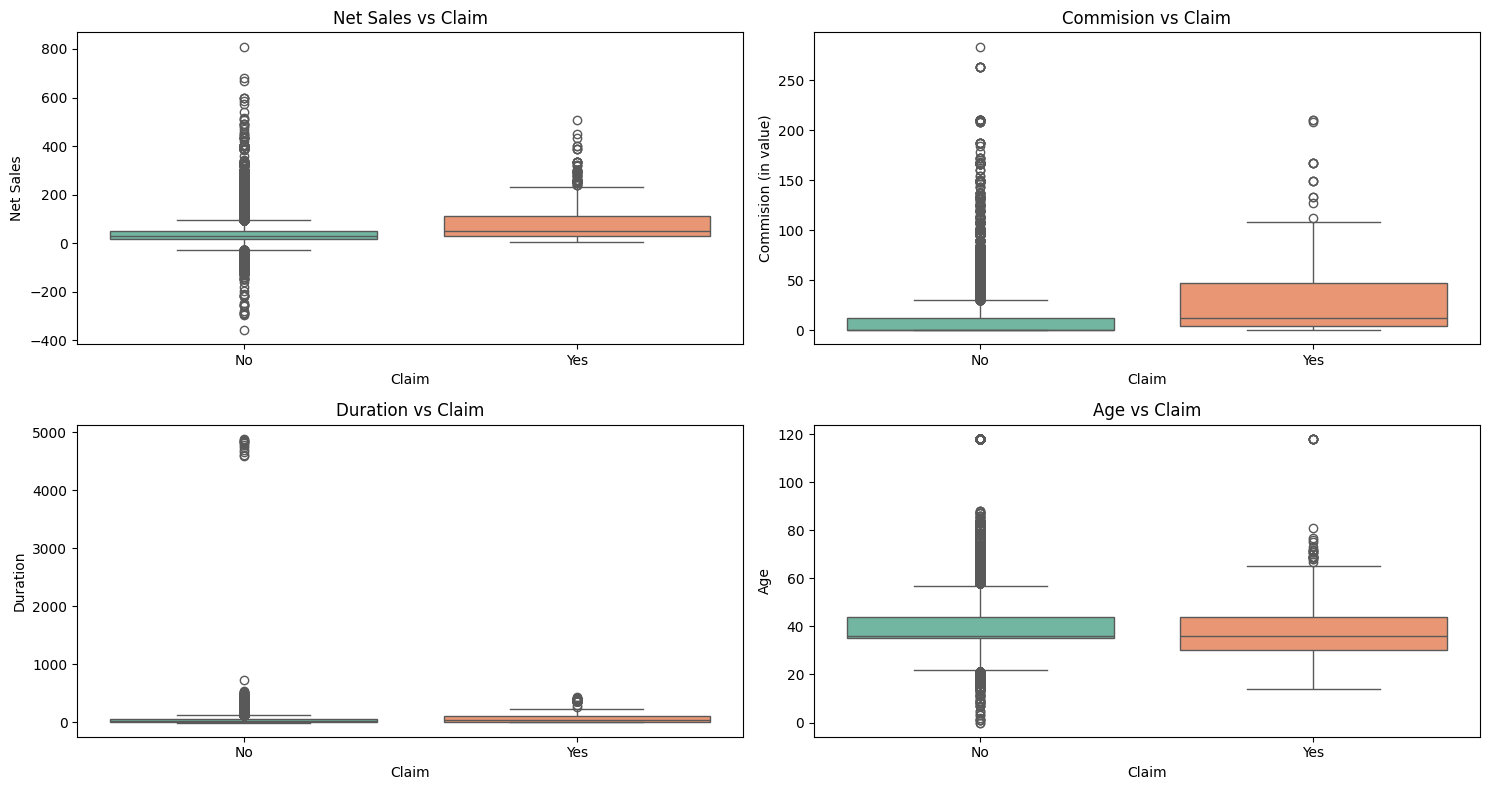

In [302]:
fig, axs = plt.subplots(2, 2, figsize=(15, 8))

sns.boxplot(x='Claim', y='Net Sales', data=dfClean, palette='Set2', ax=axs[0, 0])
axs[0, 0].set_title("Net Sales vs Claim")

sns.boxplot(x='Claim', y='Commision (in value)', data=dfClean, palette='Set2', ax=axs[0, 1])
axs[0, 1].set_title("Commision vs Claim")

sns.boxplot(x='Claim', y='Duration', data=dfClean, palette='Set2', ax=axs[1, 0])
axs[1, 0].set_title("Duration vs Claim")

sns.boxplot(x='Claim', y='Age', data=dfClean, palette='Set2', ax=axs[1, 1])
axs[1, 1].set_title("Age vs Claim")

plt.tight_layout()
plt.show()

1. Net Sales vs Claim

- Insight:

  - Net Sales untuk klaim “Yes” memiliki nilai median yang lebih tinggi dibanding “No”.
  - Distribusinya juga lebih menyebar (interquartile range lebih lebar).
  - Terdapat beberapa outlier negatif pada “No”, mungkin refund atau pembatalan.

- Korelasi:
  - Net Sales lebih tinggi berasosiasi dengan klaim — bisa jadi pelanggan yang mengeluarkan biaya lebih tinggi cenderung mengajukan klaim.

2. Commision vs Claim

- Insight:
  - Klaim “Yes” memiliki komisi median dan IQR lebih tinggi.
  - Menunjukkan bahwa agen mendapat komisi lebih tinggi dari transaksi yang menghasilkan klaim.

- Korelasi:
  - Terdapat hubungan positif antara tingginya komisi dan probabilitas klaim.

3. Duration vs Claim

- Insight:
  - Durasi pada klaim “No” memiliki outlier ekstrem (hingga 4800 hari).
  - Durasi untuk klaim “Yes” cenderung lebih rendah dan lebih terfokus.

- Korelasi:
  - Klaim lebih sering terjadi pada perjalanan berdurasi pendek hingga menengah.
  - Durasi panjang mungkin justru lebih terencana dan lebih jarang klaim.

4. Age vs Claim

- Insight:
  - Median umur antara “No” dan “Yes” tidak terlalu jauh berbeda (sekitar 35–40 tahun).
  - Terdapat outliers usia tinggi.

- Korelasi:
  - Umur tidak memiliki perbedaan distribusi yang signifikan terhadap klaim, sehingga korelasinya lemah.

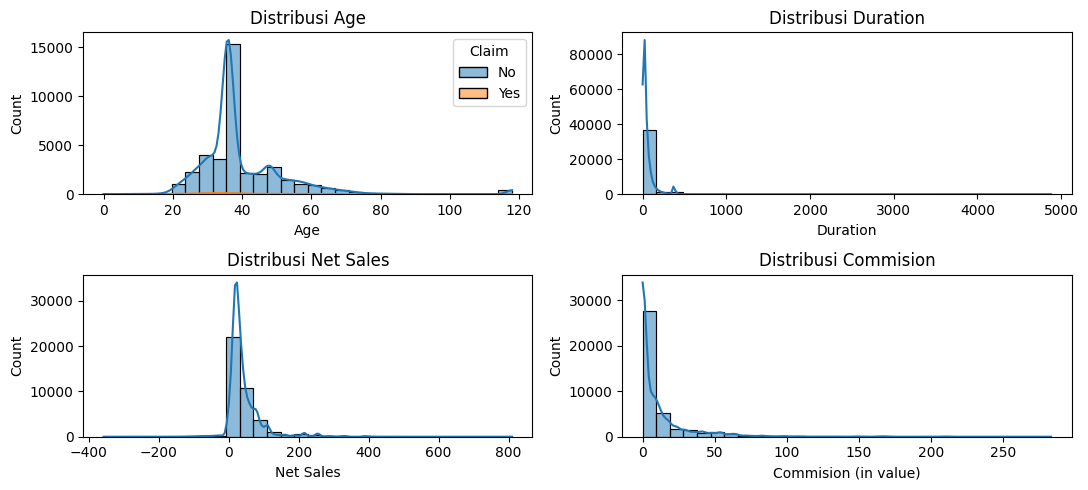

In [303]:
fig, axs = plt.subplots(2, 2, figsize=(11, 5))

sns.histplot(data=dfClean, x='Age', hue='Claim', bins=30, kde=True, ax=axs[0, 0])
axs[0, 0].set_title("Distribusi Age")

sns.histplot(dfClean['Duration'], bins=30, kde=True, ax=axs[0, 1])
axs[0, 1].set_title("Distribusi Duration")

sns.histplot(dfClean['Net Sales'], bins=30, kde=True, ax=axs[1, 0])
axs[1, 0].set_title("Distribusi Net Sales")

sns.histplot(dfClean['Commision (in value)'], bins=30, kde=True, ax=axs[1, 1])
axs[1, 1].set_title("Distribusi Commision")

plt.tight_layout()
plt.show()

**Insights**:

1. Distribusi Age

  - Mayoritas pelanggan berusia antara 30–40 tahun.
  - Claim (Yes) tampak lebih sedikit dari usia manapun, namun sedikit naik di usia 30-an akhir hingga 40-an.
  - Tidak ada korelasi kuat yang terlihat secara langsung dari distribusi, namun bisa dicurigai bahwa usia di atas 40 tahun cenderung sedikit lebih rentan melakukan klaim.

2. Distribusi Duration
  - Distribusi sangat miring ke kanan (right-skewed), mayoritas durasi < 100 hari.
  - Durasi yang lebih panjang mungkin berkaitan dengan peluang klaim lebih tinggi.

3. Distribusi Net Sales
  - Skew kanan parah, dengan banyak nilai di bawah 100, dan beberapa outlier ekstrem hingga 800.
  - Produk dengan Net Sales tinggi lebih cenderung di-claim (bisa jadi karena nilai tanggungannya besar).

4. Distribusi Commision
  - Distribusi sangat skew ke kanan, sebagian besar komisi < 10.
  - Produk dengan komisi tinggi lebih berisiko atau lebih kompleks, sehingga lebih mungkin di-claim.
  - Komisi tinggi → potensi klaim meningkat.

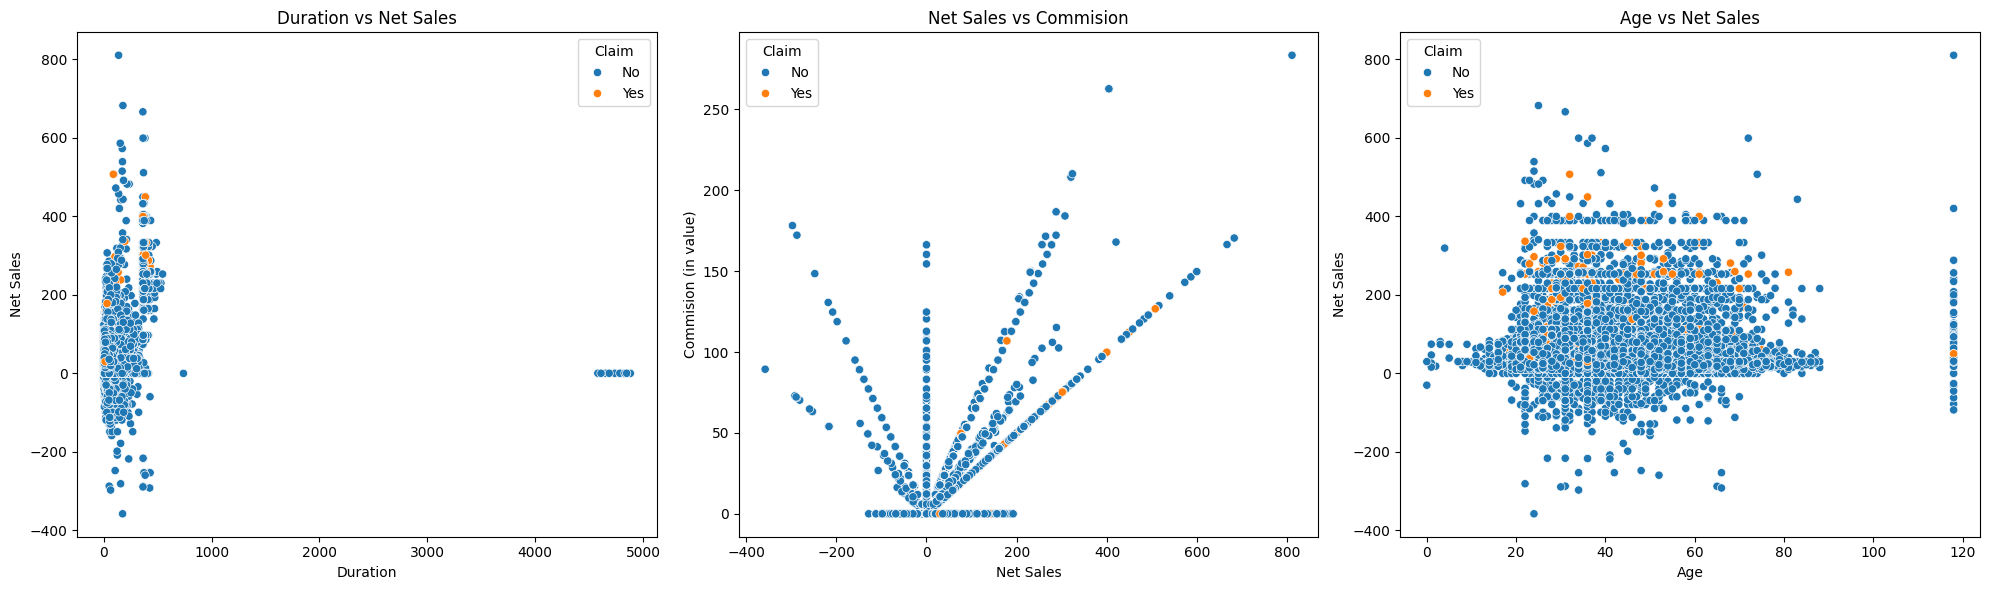

In [304]:
dfClean['Claim_encoded'] = dfClean['Claim'].map({'Yes': 1, 'No': 0})

fig, axs = plt.subplots(1, 3, figsize=(20, 6))

sns.scatterplot(x='Duration', y='Net Sales', hue='Claim', data=dfClean, ax=axs[0])
axs[0].set_title("Duration vs Net Sales")

sns.scatterplot(x='Net Sales', y='Commision (in value)', hue='Claim', data=dfClean, ax=axs[1])
axs[1].set_title("Net Sales vs Commision")

sns.scatterplot(x='Age', y='Net Sales', hue='Claim', data=dfClean, ax=axs[2])
axs[2].set_title("Age vs Net Sales")

plt.tight_layout()
plt.show()

**Insights**:

1. Duration vs Net Sales
  - Tampak cluster padat di bawah duration < 200 dan net sales antara 0–300.
  - Ada beberapa outlier dengan duration ekstrem > 4000, semuanya Claim = No.
  - Titik Claim = Yes (oranye) cenderung berada di rentang net sales tinggi (>200) dan duration sedang (~100–500).

2. Net Sales vs Commision
  - Korelasi linear jelas: semakin tinggi net sales, semakin tinggi komisi.
  - Claim = Yes (oranye) juga lebih dominan di komisi tinggi & net sales tinggi.
  - Korelasi kuat antara Net Sales dan Commision → bisa menimbulkan multikolinearitas.

3. Age vs Net Sales
  - Tidak ada pola hubungan linear jelas.
  - Claim = Yes cenderung muncul lebih banyak di usia 30–50, terutama pada Net Sales > 100.
  - Tidak ada hubungan linier langsung antara usia dan net sales → korelasi lemah.
  - Namun, usia 30–50 + net sales tinggi bisa menjadi segmen berisiko.

## **Define X and y**

Selanjutnya dilakukan define X and y, dengan X atau target yang diinginkan dari dataset Travel Insurance adalah mengetahui seberapa banyak atau kategori pelanggan seperti apa yang mempengaruhi 'Claim'.

In [305]:
X = dfClean.drop(['Claim', 'Claim_encoded'], axis=1)
y = dfClean['Claim_encoded']

display((X.head()), (y.head()))

,Agency,Agency Type,Distribution Channel,Product Name,Duration,Destination,Net Sales,Commision (in value),Age
0,C2B,Airlines,Online,Annual Silver Plan,365,SINGAPORE,216.0,54.0,57
1,EPX,Travel Agency,Online,Cancellation Plan,4,MALAYSIA,10.0,0.0,33
2,JZI,Airlines,Online,Basic Plan,19,INDIA,22.0,7.7,26
3,EPX,Travel Agency,Online,2 way Comprehensive Plan,20,UNITED STATES,112.0,0.0,59
4,C2B,Airlines,Online,Bronze Plan,8,SINGAPORE,16.0,4.0,28


,Claim_encoded
0,0
1,0
2,0
3,0
4,0


In [306]:
print(y.value_counts(normalize=True))

y_pred_all_zero = np.zeros_like(y, dtype=int)
tn, fp, fn, tp = confusion_matrix(y, y_pred_all_zero).ravel()

print(f"Jika prediksi semua 0:")
print(f"True Negative (TN): {tn}")
print(f"False Positive (FP): {fp}")
print(f"False Negative (FN): {fn}")
print(f"True Positive (TP): {tp}")

Claim_encoded
0    0.982886
1    0.017114
Name: proportion, dtype: float64
Jika prediksi semua 0:
True Negative (TN): 38651
False Positive (FP): 0
False Negative (FN): 673
True Positive (TP): 0


## **Data Splitting**

In [307]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=y
)

## **Preprocessing**

Dalam preprocessing dataset Travel Insurance, dilakukan Robust Scaling pada fitur numerikal seperti Age, Duration, Net Sales, dan Commision (in value) karena data bersifat skewed dan mengandung outlier. Sementara itu, fitur seperti Agency, Agency Type, Distribution Channel, Product Name, dan Destination diolah menggunakan OneHot Encoding karena merupakan data kategorikal nominal dengan banyak kelas dan tidak memiliki urutan. Target Claim dikonversi dari label (‘Yes’/’No’) ke numerik (1/0) agar sesuai dengan format input model klasifikasi.

In [308]:
numeric_features = ['Age', 'Duration', 'Net Sales', 'Commision (in value)']
numeric_transformer = RobustScaler()

categorical_ohe = ['Agency', 'Agency Type', 'Distribution Channel', 'Product Name', 'Destination']
categorical_transformer_ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

In [309]:
transformer = ColumnTransformer([
        ('num', numeric_transformer, numeric_features),
        ('cat_ohe', categorical_transformer_ohe, categorical_ohe)
    ], remainder = 'passthrough')

In [310]:
transformer.fit(X_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('num', RobustScaler(),
                                 ['Age', 'Duration', 'Net Sales',
                                  'Commision (in value)']),
                                ('cat_ohe',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse_output=False),
                                 ['Agency', 'Agency Type',
                                  'Distribution Channel', 'Product Name',
                                  'Destination'])])

## **Cross Validation**

In [311]:
# Define scoring
scoring = {
    'f1': 'f1',
    'f2': make_scorer(fbeta_score, beta=2),
    'roc_auc': 'roc_auc'
}

# Define models
models = {
    'LogReg': LogisticRegression(class_weight='balanced', max_iter=500),
    'KNN': KNeighborsClassifier(),
    'RandomForest': RandomForestClassifier(class_weight='balanced', random_state=42)
}

# Define samplers
resamplers = {
    'RandomUnder': RandomUnderSampler(random_state=42),
    'NearMiss': NearMiss()
}

In [312]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

results = []

for sampler_name, sampler in resamplers.items():
    for model_name, model in models.items():
        pipe = ImbPipeline([
            ('preprocess', transformer),
            ('resample', sampler),
            ('model', model)
        ])

        cv_result = cross_validate(pipe, X_train, y_train,
                                   scoring=scoring,
                                   cv=skf,
                                   return_train_score=False,
                                   n_jobs=-1)

        results.append({
            'Model': model_name,
            'Sampler': sampler_name,
            'F1 Mean': cv_result['test_f1'].mean(),
            'F2 Mean': cv_result['test_f2'].mean(),
            'ROC AUC Mean': cv_result['test_roc_auc'].mean(),
            'F2 Std': cv_result['test_f2'].std()
        })

results_df = pd.DataFrame(results).sort_values(by='F2 Mean', ascending=False)
display(results_df)

,Model,Sampler,F1 Mean,F2 Mean,ROC AUC Mean,F2 Std
0,LogReg,RandomUnder,0.101095,0.207735,0.807150,0.004056
2,RandomForest,RandomUnder,0.086898,0.184312,0.787022,0.009494
1,KNN,RandomUnder,0.081695,0.174747,0.776566,0.010111
5,RandomForest,NearMiss,0.029474,0.070033,0.342844,0.002140
4,KNN,NearMiss,0.028044,0.066509,0.368665,0.001296
3,LogReg,NearMiss,0.026060,0.061800,0.324959,0.003442


Berdasarkan nilai F2 Mean, Logistic Regression dengan RandomUnderSampler menjadi model yang terbaik, yaitu dengan nilai: 0.207

## **Hyperparameter Tuning**

In [313]:
f2_scorer = make_scorer(fbeta_score, beta=2)

**Logistic Regression + RandomUnderSampler**

In [314]:
pipe_logreg_ru = ImbPipeline([
    ('preprocess', transformer),
    ('resample', RandomUnderSampler(random_state=42)),
    ('model', LogisticRegression(class_weight='balanced', solver='liblinear', random_state=42))
])

param_logreg_ru = {
    'model__C': [0.01, 0.1, 1, 10, 100],
    'model__penalty': ['l1', 'l2']
}

search_logreg_ru = RandomizedSearchCV(
    estimator=pipe_logreg_ru,
    param_distributions=param_logreg_ru,
    n_iter=10,
    scoring=f2_scorer,
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

search_logreg_ru.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocess',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('num',
                                                                               RobustScaler(),
                                                                               ['Age',
                                                                                'Duration',
                                                                                'Net '
                                                                                'Sales',
                                                                                'Commision '
                                                                                '(in '
                                                                                'value)']),
                                                                              ('cat_ohe',
                                                                               OneHotEncoder(handle_unknown='ignore',
                                                                                             sparse_output=False),
                                                                               ['Agency',
                                                                                'Agency '
                                                                                'Type',
                                                                                'Distribution '
                                                                                'Channel',
                                                                                'Product '
                                                                                'Name',
                                                                                'Destination'])])),
                                             ('resample',
                                              RandomUnderSampler(random_state=42)),
                                             ('model',
                                              LogisticRegression(class_weight='balanced',
                                                                 random_state=42,
                                                                 solver='liblinear'))]),
                   n_jobs=-1,
                   param_distributions={'model__C': [0.01, 0.1, 1, 10, 100],
                                        'model__penalty': ['l1', 'l2']},
                   random_state=42,
                   scoring=make_scorer(fbeta_score, response_method='predict', beta=2),
                   verbose=1)

In [315]:
print("LogReg + RandomUnder Best Params:", search_logreg_ru.best_params_)
print("LogReg + RandomUnder Best F2 Score:", search_logreg_ru.best_score_)

LogReg + RandomUnder Best Params: {'model__penalty': 'l1', 'model__C': 0.1}
LogReg + RandomUnder Best F2 Score: 0.23259725051495833


## **Predict Test**

**sebelum hyperparameter tuning**

In [316]:
logreg_ru_default = ImbPipeline([
    ('preprocess', transformer),
    ('resample', RandomUnderSampler(random_state=42)),
    ('model', LogisticRegression(class_weight='balanced', solver='liblinear', random_state=42))
])

logreg_ru_default.fit(X_train, y_train)

y_pred_logreg_default = logreg_ru_default.predict(X_test)

print("LogReg + RandomUnder - F2 Score Sebelum Tuning:", fbeta_score(y_test, y_pred_logreg_default, beta=2))


LogReg + RandomUnder - F2 Score Sebelum Tuning: 0.2291861552853134


**setelah hyperparameter tuning**

In [317]:
logreg_ru_best = search_logreg_ru.best_estimator_

y_pred_logreg_best = logreg_ru_best.predict(X_test)

print("LogReg + RandomUnder - F2 Score Setelah Tuning:", fbeta_score(y_test, y_pred_logreg_best, beta=2))
print(classification_report(y_test, y_pred_logreg_best))
ConfusionMatrixDisplay.from_estimator(logreg_ru_best, X_test, y_test)

LogReg + RandomUnder - F2 Score Setelah Tuning: 0.2344139650872818
              precision    recall  f1-score   support

           0       0.99      0.82      0.90      7730
           1       0.06      0.70      0.12       135

    accuracy                           0.82      7865
   macro avg       0.53      0.76      0.51      7865
weighted avg       0.98      0.82      0.89      7865



1. F2 Score: 0.2344
  - F2-score berfokus pada recall → cocok untuk kasus di mana False Negative (FN) sangat berisiko (asuransi).
  - Nilai F2 meningkat sedikit setelah tuning (dari 0.229 menjadi 0.234) → perbaikan kecil dalam menangkap klaim.

2. Classification Report
  - Precision Rendah (0.06) untuk klaim → banyak False Positives: model sering menduga pelanggan klaim padahal tidak.
  - Recall Tinggi (0.70) → 70% dari total pelanggan yang benar-benar klaim berhasil ditangkap.
  - F1-score rendah (0.12) untuk klaim → karena precision rendah, walau recall cukup tinggi.

3. Confusion Matrix
  - True Positive (TP) = 94 → Model berhasil mendeteksi 94 pelanggan yang benar-benar klaim.
  - False Negative (FN) = 41 → Ada 41 pelanggan yang seharusnya klaim, namun tidak terdeteksi.
  - False Positive (FP) = 1,371 → Model salah mengira 1.371 pelanggan tidak klaim sebagai klaim.
  - True Negative (TN) = 6,359 → Model berhasil mengidentifikasi pelanggan yang tidak klaim.

## **Feature Importance**

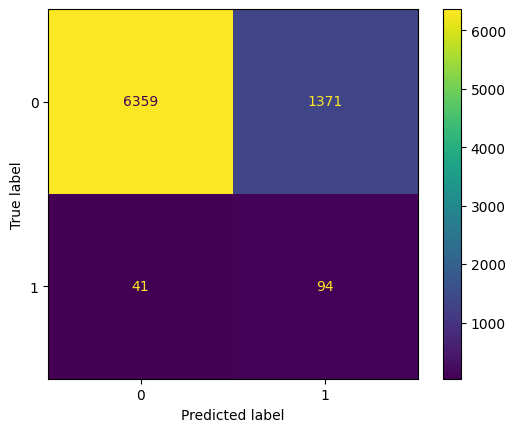

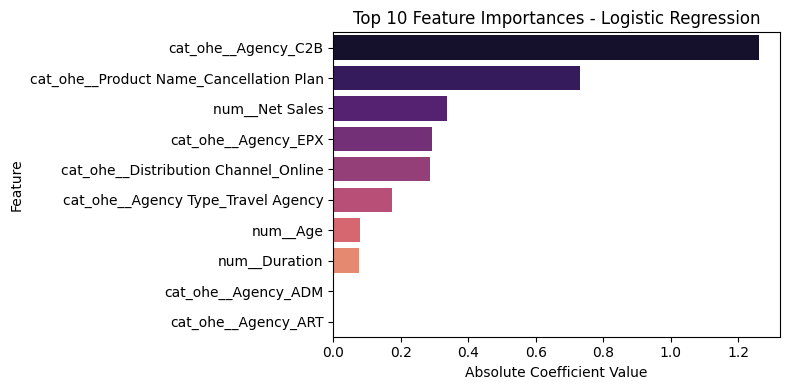

In [318]:
best_logreg = search_logreg_ru.best_estimator_.named_steps['model']

feature_names = transformer.get_feature_names_out()

coefficients = best_logreg.coef_[0]

feat_imp_logreg = pd.Series(coefficients, index=feature_names).abs().sort_values(ascending=False).head(10)

plt.figure(figsize=(8, 4))
sns.barplot(x=feat_imp_logreg, y=feat_imp_logreg.index, palette="magma")
plt.title("Top 10 Feature Importances - Logistic Regression")
plt.xlabel("Absolute Coefficient Value")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

Insights:
- Agen dan Produk adalah faktor yang paling berpengaruh terhadap klaim.
- Net Sales secara konsisten muncul sebagai faktor penting — mendukung hipotesis bahwa nilai transaksi tinggi → potensi klaim tinggi.
- Distribusi Online dan atribut demografis (usia, durasi) juga ikut berkontribusi, namun tidak sebesar jenis agen/produk.

## **Explainable AI**

Tujuan:
- SHAP (SHapley Additive exPlanations) untuk melihat kontribusi fitur global dan lokal.
- LIME (Local Interpretable Model-agnostic Explanations) untuk menjelaskan prediksi individual customer.

**SHAP**

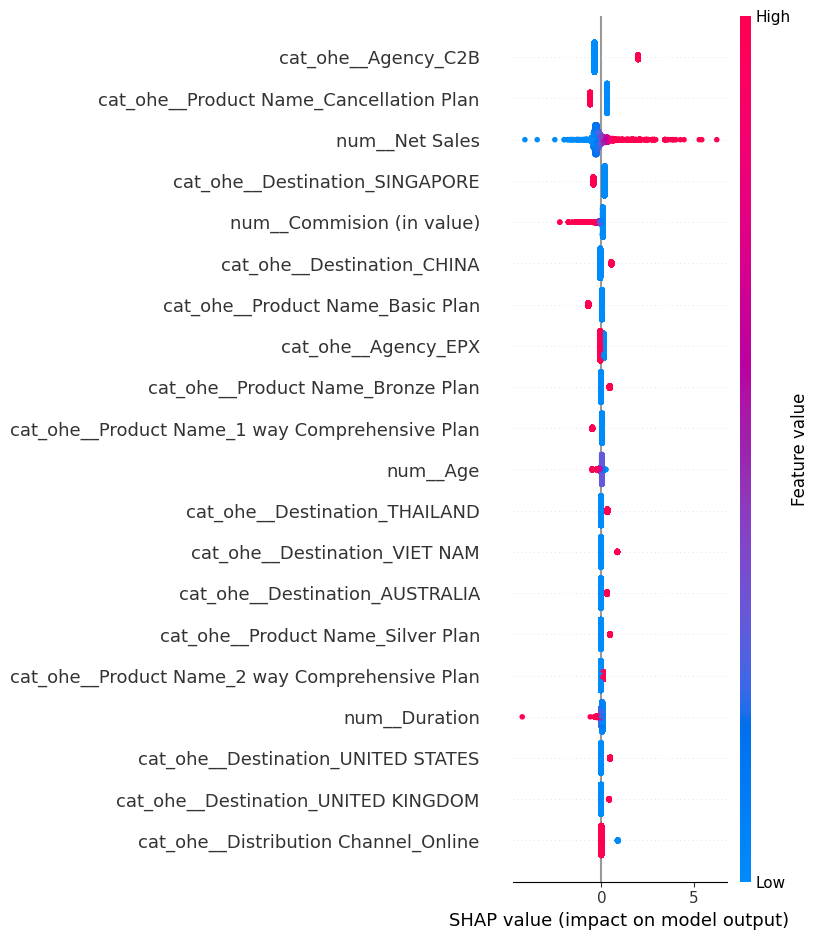

In [319]:
X_train_transformed = transformer.transform(X_train)
X_test_transformed = transformer.transform(X_test)

best_logreg = search_logreg_ru.best_estimator_.named_steps['model']
best_logreg.fit(X_train_transformed, y_train)

explainer = shap.Explainer(best_logreg, X_train_transformed, feature_names=feature_names)

shap_values = explainer(X_test_transformed)

shap.summary_plot(shap_values, X_test_transformed)

Grafik ini menunjukkan:
- Sumbu Y: Fitur-fitur yang paling berpengaruh pada prediksi.
- Sumbu X: Nilai SHAP → seberapa besar pengaruh fitur terhadap probabilitas klaim asuransi.
- Warna: Menunjukkan nilai fitur (merah = tinggi, biru = rendah).

Insights:
- Agen penjualan (C2B, EPX), jenis produk (Cancellation Plan), dan negara tujuan berperan besar terhadap prediksi klaim.
- Variabel numeric seperti Net Sales, Komisi, dan Umur juga memengaruhi, tetapi tidak sekuat fitur kategori.
- SHAP membantu mengkonfirmasi bahwa model mempelajari hubungan yang masuk akal secara domain bisnis (e.g., transaksi besar dan produk sensitif → peluang klaim tinggi).

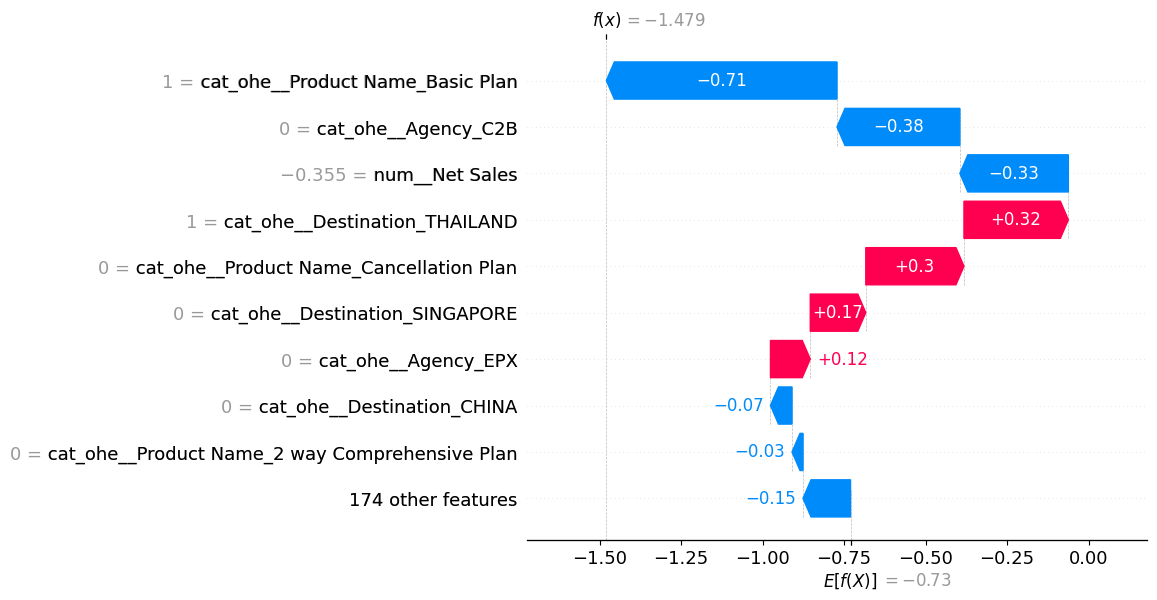

In [320]:
shap.plots.waterfall(shap_values[0])

Plot ini menjelaskan bagaimana fitur-fitur berkontribusi terhadap prediksi probabilitas klaim untuk satu individu pelanggan. Model yang digunakan adalah Logistic Regression dengan output log-odds (f(x)).
- Sumbu horizontal: Nilai log-odds prediksi.
- E(f(X)) = -0.73: Rata-rata prediksi model (log-odds), setara dengan probabilitas dasar (sebelum pengaruh fitur).
- f(x) = -1.479: Prediksi akhir untuk pelanggan ini dalam log-odds, menunjukkan kemungkinan rendah untuk klaim.
- Warna biru: Fitur yang menurunkan prediksi klaim.
- Warna merah: Fitur yang menaikkan prediksi klaim.

Insights:

**Fitur yang Menurunkan Kemungkinan Klaim**
- Product Name = Basic Plan → kontribusi: -0.71
  - Pelanggan dengan Basic Plan cenderung tidak melakukan klaim.
- Agency = C2B → kontribusi: -0.38
  - Tidak menggunakan agency C2B → menurunkan prediksi klaim.
- Net Sales = -0.355 → kontribusi: -0.33
  - Nilai transaksi rendah → kemungkinan klaim lebih kecil.
- Product Name = 2 way Comprehensive Plan dan tujuan ke CHINA → kontribusi kecil negatif.

**Fitur yang Menaikkan Kemungkinan Klaim**
- Destination = THAILAND → kontribusi: +0.32
  - Destinasi ini memiliki keterkaitan dengan pelanggan yang lebih sering klaim.
- Product Name = Cancellation Plan → kontribusi: +0.30
  - Produk ini secara umum memang memicu klaim lebih tinggi karena tujuannya melindungi pembatalan.
- Destination = SINGAPORE dan Agency = EPX → kontribusi positif kecil.

Kesimpulan:
- Total kontribusi negatif lebih besar → model memprediksi probabilitas rendah bahwa pelanggan ini akan mengajukan klaim.
- Nilai f(x) = -1.479 dalam log-odds setara dengan probabilitas klaim sekitar ~18%, masih jauh dari ambang batas default (biasanya 0.5).

**LIME**

In [321]:
# !pip install shap lime

In [322]:
lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train_transformed,
    feature_names=feature_names,
    class_names=['No Claim', 'Claim'],
    mode='classification'
)

i = 0
lime_exp = lime_explainer.explain_instance(
    data_row=X_test_transformed[i],
    predict_fn=best_logreg.predict_proba
)

lime_exp.show_in_notebook(show_table=True)

Insights:

**1. Fitur yang Mendorong Prediksi “No Claim”**

Fitur-fitur ini mengurangi probabilitas klaim:
- Agency_C2B → 0.46
- Agency_LWC → 0.32
- Agency_JWT → 0.22
- Destination_ICELAND, VIET NAM, FRANCE, ITALY → ~0.2 masing-masing

Artinya, pelanggan ini menggunakan agency tertentu (C2B, LWC, JWT) dan memiliki tujuan destinasi (seperti Islandia, Vietnam, Prancis, Italia) yang berdasarkan data historis jarang dikaitkan dengan klaim asuransi, sehingga memperkuat keputusan untuk memprediksi “No Claim.”

**2. Fitur yang Mendorong Prediksi “Claim”**

Fitur-fitur ini meningkatkan kemungkinan klaim, namun kontribusinya relatif kecil:
- Agency_ART → 0.17
- Destination_LEBANON → 0.07
- Destination_MACEDONIA → 0.02

Walaupun fitur ini mendorong model ke arah "Claim", kontribusinya tidak cukup kuat untuk mengubah keputusan akhir.

**Kesimpulan**:

Model Logistic Regression dengan RandomUnderSampler memutuskan pelanggan ini tidak akan klaim asuransi, dan ini terutama didorong oleh agen perjalanan dan destinasi yang secara historis tidak banyak melakukan klaim. Ini membantu tim bisnis dalam mengenali karakteristik pelanggan yang cenderung tidak menimbulkan risiko klaim.

## **Conclusion and Recommendation**

**Conclusion**

1. Model terbaik adalah Logistic Regression dengan RandomUnderSampler, karena mampu memberikan keseimbangan terbaik antara recall (70%) dan F2-score (0.234), sesuai dengan fokus bisnis pada meminimalkan False Negatives (yaitu, pelanggan yang seharusnya klaim tapi diprediksi tidak klaim).

2. Feature yang paling berpengaruh dalam prediksi klaim antara lain:
  - Agency_C2B, Product Name_Cancellation Plan, dan Net Sales.
  - Pelanggan dari agen C2B cenderung tidak mengajukan klaim.
  - Produk Cancellation Plan dan nilai penjualan yang rendah cenderung dikaitkan dengan klaim.

3. SHAP dan LIME mendukung hasil ini, menunjukkan bahwa kombinasi produk, agen, destinasi, dan nilai transaksi sangat memengaruhi prediksi klaim.

4. Model cukup akurat secara keseluruhan (accuracy 82%), tetapi tetap memperlihatkan tantangan dalam mengenali minoritas (kelas ‘Claim’) karena distribusi data yang imbalanced.

**Recommendation**

1. Untuk Tim Asuransi dan Manajemen Risiko:
- Fokuskan pengawasan ekstra pada pelanggan yang membeli produk Cancellation Plan, menggunakan agen non-C2B, dan memiliki net sales rendah, karena mereka memiliki kecenderungan lebih tinggi untuk klaim.

2. Untuk Pemasaran:
- Pertimbangkan untuk mendesain ulang atau membatasi produk yang sering diklaim seperti Cancellation Plan agar tetap menguntungkan tanpa meningkatkan risiko klaim.

3. Untuk Pengembangan Model Lanjutan:
- Pertimbangkan teknik tambahan seperti:
  - Cost-sensitive learning untuk menyesuaikan penalti False Negative.
  - Ensemble stacking atau threshold tuning lanjutan untuk menyeimbangkan metrik.
  - Segmentasi klaster (unsupervised) sebagai tahap pra-klasifikasi untuk menyesuaikan model terhadap segmen risiko tertentu.

4. Untuk Interpretabilitas:
- Gunakan hasil SHAP/LIME untuk membuat sistem explainable AI dashboard yang bisa membantu tim underwriting atau CS dalam memahami keputusan model terhadap klaim pelanggan secara individual.

In [323]:
import pickle

In [328]:
with open('travel_insurance.pkl', 'wb') as file:
    pickle.dump(logreg_ru_best, file)

In [329]:
with open('travel_insurance.pkl', 'rb') as file:
    loaded_model = pickle.load(file)

In [330]:
import os
os.listdir()

['.config',
 'travel_insurance.pkl',
 'logreg_randomunder.pkl',
 'data_travel_insurance.csv',
 'drive',
 'sample_data']

In [331]:
!ls

data_travel_insurance.csv  logreg_randomunder.pkl  travel_insurance.pkl
drive			   sample_data


In [332]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [333]:
with open('/content/drive/MyDrive/logreg_randomunder.pkl', 'wb') as file:
    pickle.dump(logreg_ru_best, file)

In [334]:
print(os.getcwd())

/content
